# Naive Bayes

## Introduction

We will start by working on the Iris dataset. Recall that Iris dataset contains iris species and sepal and petal measurements. We will quickly explore the dataset and jump into Naive Bayes.

In [1]:
from __future__ import print_function
import os
#Data Path has to be set as per the file location in your system
#data_path = ['..', 'data']
data_path = ['data']

## Question 1

* Load the Iris dataset.
* Take a quick look at the data types.
* Look at the skew values and decide if any transformations need to be applied. You can use skew value 0.75 as a threshold.
* Use `sns.pairplot` to plot the pairwise correlations and histograms. Use `hue="species"` as a keyword argument in order to see the distribution of species.

In [2]:
import pandas as pd
import numpy as np
#The filepath is dependent on the data_path set in the previous cell 
filepath = os.sep.join(data_path + ['Iris_Data.csv'])
data = pd.read_csv(filepath, sep=',', header=0)

In [3]:
data.dtypes

sepal_length    float64
sepal_width     float64
petal_length    float64
petal_width     float64
species          object
dtype: object

Notice that aside from the predictor variable, everything is float.

In [4]:
skew = pd.DataFrame(data.skew())
skew.columns = ['skew']
skew['too_skewed'] = skew['skew'] > .75
skew

,skew,too_skewed
sepal_length,0.314911,False
sepal_width,0.334053,False
petal_length,-0.274464,False
petal_width,-0.104997,False


Fields are not too badly skewed.

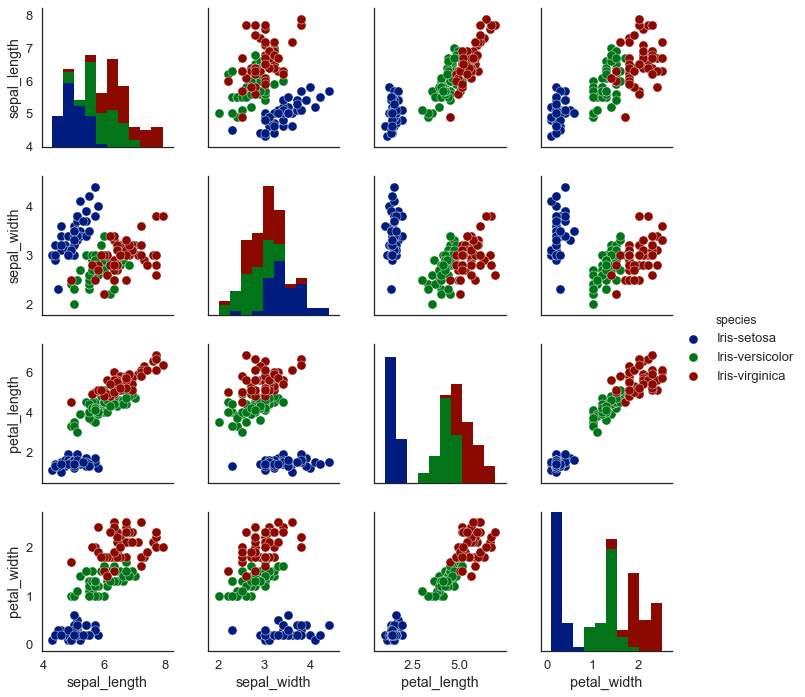

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_context('talk')
sns.set_style('white')
sns.set_palette('dark')

sns.pairplot(data, hue='species')

## Question 2

Let's now fit a Naive Bayes classifier to this data in order to predict "species".

* Pick the appropriate type of Naive Bayes given the nature of your dataset (data types of columns). Recall, choices are
    * GaussianNB
    * MultinomialNB
    * BernoulliNB
* Use `cross_val_score` to see how well your choice works.

In [6]:
# Since the features are continuous, the right choice is GaussianNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
X = data[data.columns[:-1]]
y = data.species

GNB = GaussianNB()
cv_N = 4
scores = cross_val_score(GNB, X, y, n_jobs=cv_N, cv=cv_N)
print(scores)
np.mean(scores)

[0.94871795 0.94871795 0.91666667 1.        ]


0.953525641025641

## Question 3:

Now let's try all types of Naive Bayes and observe what happens

* Compare the cross validation scores for Gaussian, Bernouilli and Multinomial Naive Bayes.
* Why is BernoulliNB performing like it does?

In [7]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
X = data[data.columns[:-1]]
y = data.species
nb = {'gaussian': GaussianNB(),
      'bernoulli': BernoulliNB(),
      'multinomial': MultinomialNB()}
scores = {}
for key, model in nb.items():
    s = cross_val_score(model, X, y, cv=cv_N, n_jobs=cv_N, scoring='accuracy')
    scores[key] = np.mean(s)
scores

{'gaussian': 0.953525641025641,
 'bernoulli': 0.3333333333333333,
 'multinomial': 0.9529914529914529}

Looks like BernoulliNB results are very bad, but MultinomialNB is doing a very good job.<br/>
Why are the results of Bernoulli bad? Find out the reason.<br/>
In the [scikit-learn documentation for Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html) we find that the Bernoulli Naive Bayes class `BernoulliNB` expects binary (Boolean)-valued features, and otherwise binarizes the input. Therefore, `BernoulliNB` has interpretted our input of (nonnegative) plant measurements as a matrix of ones, and will always make the same prediction regardless of input.

## Question 4:

Let's see what happens when we take away the predictive features.

* Check the pairplot histograms (diagonal) you produced above and identify the two most predictive features visually.
* Remove the *petal_* features which are very predictive, and re-do the comparison above. That is, get the cross validation scores for all types of Naive Bayes.

In [8]:
X = data[['sepal_length', 'sepal_width']]
y = data.species

nb = {'gaussian': GaussianNB(),
      'bernoulli': BernoulliNB(),
      'multinomial': MultinomialNB()}

# Try other variants on the lines shown in the previous cell for GaussianNB and compare the results on scoring = 'accuracy'. 
# Run the piece of code as shown in array in question 3
scores = {}
for key, model in nb.items():
    s = cross_val_score(model, X, y, cv=cv_N, n_jobs=cv_N, scoring='accuracy')
    scores[key] = np.mean(s)
scores

{'gaussian': 0.7879273504273504,
 'bernoulli': 0.3333333333333333,
 'multinomial': 0.6800213675213675}

Come up with your observations after taking away the very predictive features, which model works better:<br/>
It turns out that after excluding/ignoring the features which were more predictive of the target from our model, the cross validation scores decreased. One might conclude that the Gaussian and Multinomial Naive Bayes models both work better when including useful/predictive features.

## Question 5

This question explores how Naive Bayes algorithms can be affected when we push the underlying (naive) assumption too much. Recall that the naive assumption is that the features in the training set are *independent* from each other.

* Create **0, 1, 3, 5, 10, 50, 100** copies of `sepal_length` and fit a `GaussianNB` for each one.
* Keep track of the save the average `cross_val_score`.
* Create a plot of the saved scores over the number of copies.

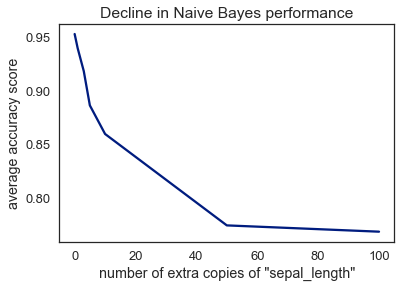

In [9]:
X = data[data.columns[:-1]]
y = data.species

n_copies = [0, 1, 3, 5, 10, 50, 100]


def create_copies_sepal_length(X, n):
    X_new = X.copy()
    for i in range(n):
        X_new['sepal_length_copy%s' % i] = X['sepal_length']
    return X_new


def get_cross_val_score(n):
    X_new = create_copies_sepal_length(X, n)
    scores = cross_val_score(GaussianNB(), X_new, y, cv=cv_N, n_jobs=cv_N)
    return np.mean(scores)


avg_scores = pd.Series(
    [get_cross_val_score(n) for n in n_copies],
    index=n_copies)

ax = avg_scores.plot()
ax.set(xlabel='number of extra copies of "sepal_length"', ylabel='average accuracy score',
       title='Decline in Naive Bayes performance');

## Question 6 - Naive Bayes on Human Activity Recongnition

In this question, we'll explore discretizing the dataset and then fitting MultinomialNB.  

* Load the Human Activity Recognition dataset. 
* Look at the data types. It's all continuous except for the target.
* Create `X` and `y` from `data`. `y` is the "Activity" column.
* Create training and test splits.
* Fit a GaussianNB to the training split.
* Get predictions on the test set.
* use `sns.heatmap` to plot the confusion matrix for predictions.

In [10]:
import pandas as pd
import numpy as np
#The filepath is dependent on the data_path set in the previous cell 
filepath = os.sep.join(data_path + ['Human_Activity_Recognition_Using_Smartphones_Data.csv'])
data = pd.read_csv(filepath, sep=',')

In [11]:
data.dtypes.value_counts()

float64    561
object       1
dtype: int64

We use Scikit-learn's `StratifiedShuffleSplit` to maintain the same ratio of predictor classes in 'Activity'.

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

feature_cols = data.columns[:-1]

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1,test_size=0.3, random_state=42)
train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data.Activity))

# Create the dataframes
X_train_GNB = data.loc[train_idx, feature_cols]
y_train_GNB = data.loc[train_idx, 'Activity']

X_test_GNB  = data.loc[test_idx, feature_cols]
y_test_GNB  = data.loc[test_idx, 'Activity']

In [13]:
GNB = GaussianNB().fit(X_train_GNB, y_train_GNB)
y_predict_GNB = GNB.predict(X_test_GNB)

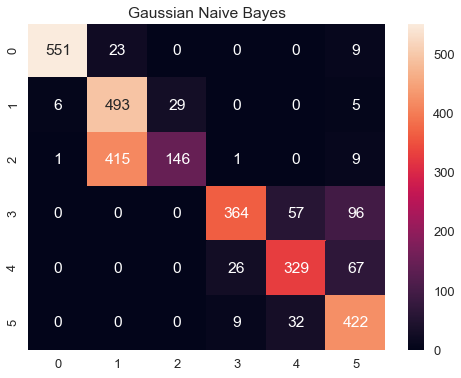

In [14]:
from sklearn.metrics import confusion_matrix
GNBcm = confusion_matrix(y_test_GNB, y_predict_GNB)

plt.figure().set_size_inches(8, 6)
ax = sns.heatmap(GNBcm, annot=True, fmt='d')
ax.set(title='Gaussian Naive Bayes');

## Question 7

Now, let's discretize the dataset from Question 6. There are many ways to do this, but we'll use `pd.DataFrame.rank(pct=True)`.

1. Create `X_discrete` from `X` using `.rank(pct=True)`. See the documentation [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rank.html).
2. Look at the values. They are still not discrete. Modify `X_discrete` so that it is indeed discrete. (Hint: try to get the first 2 digits using `.applymap`)
3. Split `X_discrete` and `y` into training and test datasets
4. Fit a MultinomialNB to the training split.
5. Get predictions on the test set.
6. Plot the confusion matrix for predictions.

In [15]:
# Rank the data in each column, so varying along the index (axis=0) as a percentage
X_discrete = data.loc[:, feature_cols].rank(pct=True)
X_discrete.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.752209,0.339839,0.162152,0.151762,0.194194,0.462181,0.185164,0.192640,0.450529,0.265948,...,0.186717,0.547238,0.490339,0.259928,0.525002,0.261773,0.491407,0.194776,0.495097,0.348092
1,0.565006,0.556559,0.226333,0.016992,0.262258,0.370619,0.008447,0.266822,0.379454,0.044956,...,0.540247,0.181183,0.208078,0.621614,0.481115,0.173124,0.915234,0.184484,0.496262,0.357608
2,0.618118,0.366929,0.357316,0.146422,0.314011,0.251966,0.112341,0.335275,0.264103,0.182299,...,0.887659,0.430916,0.406447,0.254782,0.674143,0.547723,0.956112,0.169919,0.497330,0.371104
3,0.598505,0.231479,0.228954,0.109816,0.191669,0.086222,0.082629,0.197009,0.112341,0.182299,...,0.878920,0.747160,0.753860,0.372560,0.474027,0.784154,0.195359,0.170599,0.499854,0.377221
4,0.473250,0.545393,0.324012,0.020099,0.218079,0.089426,0.020682,0.228566,0.092436,0.063064,...,0.415283,0.479755,0.507428,0.727935,0.624818,0.802505,0.127391,0.172735,0.510050,0.389358


In [16]:
# Discretize the data by rounding all data to 2 decimal places
X_percentile = X_discrete.applymap(lambda x: round(x,2))
X_percentile.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.75,0.34,0.16,0.15,0.19,0.46,0.19,0.19,0.45,0.27,...,0.19,0.55,0.49,0.26,0.53,0.26,0.49,0.19,0.50,0.35
1,0.57,0.56,0.23,0.02,0.26,0.37,0.01,0.27,0.38,0.04,...,0.54,0.18,0.21,0.62,0.48,0.17,0.92,0.18,0.50,0.36
2,0.62,0.37,0.36,0.15,0.31,0.25,0.11,0.34,0.26,0.18,...,0.89,0.43,0.41,0.25,0.67,0.55,0.96,0.17,0.50,0.37
3,0.60,0.23,0.23,0.11,0.19,0.09,0.08,0.20,0.11,0.18,...,0.88,0.75,0.75,0.37,0.47,0.78,0.20,0.17,0.50,0.38
4,0.47,0.55,0.32,0.02,0.22,0.09,0.02,0.23,0.09,0.06,...,0.42,0.48,0.51,0.73,0.62,0.80,0.13,0.17,0.51,0.39


In [17]:
# Split into training and test sets whilst preserving predictor class proportions
# That is, the proportion of each class in y_train and y_test should both reflect the proportion in y before splitting_MNB
from sklearn.model_selection import StratifiedShuffleSplit
feature_cols = data.columns[:-1]

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1,test_size=0.3, random_state=42)
train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data.Activity))

# Create the dataframes
X_train_MNB = X_percentile.loc[train_idx, :]
X_test_MNB  = X_percentile.loc[test_idx, :]

y_train_MNB = data.loc[train_idx, 'Activity']
y_test_MNB  = data.loc[test_idx, 'Activity']

In [18]:
# Fit a Multinomial Naive Bayes model on the training data
MNB = MultinomialNB().fit(X_train_MNB, y_train_MNB)

# Produce predictions for the test data
y_predict_MNB = MNB.predict(X_test_MNB)

# Compute the confusion matrix for the MNB model
MNBcm = confusion_matrix(y_test_MNB, y_predict_MNB)

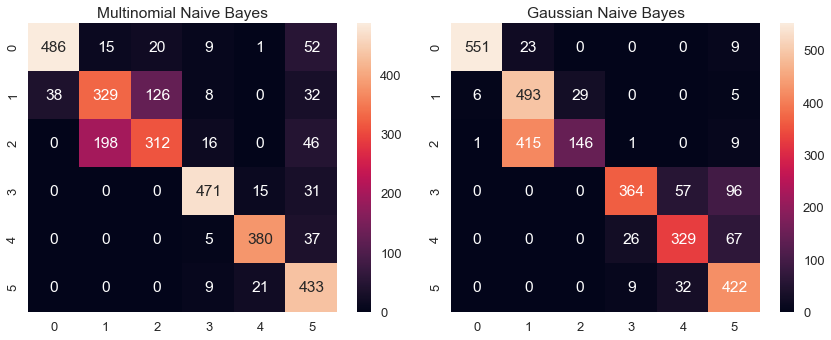

In [19]:
# Plot the confusion matrices together for comparison
fig, axList = plt.subplots(nrows=1, ncols=2)
axList = axList.flatten()

fig.set_size_inches(12, 5)
sns.heatmap(MNBcm, ax=axList[0], annot=True, fmt='d')
axList[0].set(title='Multinomial Naive Bayes');

GNBax = sns.heatmap(GNBcm, ax=axList[1], annot=True, fmt='d')
axList[1].set(title='Gaussian Naive Bayes');

plt.tight_layout()

From the confusion matrices we see that the Gaussian NB model frequently misidentifies class 2 (Sitting) as class 1 (Standing), whereas the Multinomial NB model performs better on identifying true cases of class 2 (Sitting), though still often cannot distinguish between class 1 (Standing) and 2 (Sitting). The Multinomial model performs better on the majority of classes, but overpredicts the occurence of class 5 (Walking Downstairs).

Below we compare various classification error metrics for an alternative view.

It should be noted that although these Naive Bayes models are outperformed by the logistic regression models, the Naive Bayes models are an order of magnitude quicker to run on this data.

In [20]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize

# It is necessary to encode the predictor labels as integers to calculate the ROC-AUC scores 
y_test_GNB = LabelEncoder().fit_transform(y_test_GNB)
y_predict_GNB = LabelEncoder().fit_transform(y_predict_GNB)
y_test_MNB = LabelEncoder().fit_transform(y_test_MNB)
y_predict_MNB = LabelEncoder().fit_transform(y_predict_MNB)

model_prediction_dict = {'Gaussian Naive Bayes': [y_predict_GNB, y_test_GNB], 
                         'Multinomial Naive Bayes': [y_predict_MNB, y_test_MNB]}
metrics = list()

for model, y_values in model_prediction_dict.items():
    # Precision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_values[1], y_values[0], average='weighted')
    
    # The usual way to calculate accuracy - appears to match weighted recall
    accuracy = accuracy_score(y_values[1], y_values[0])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_values[1], classes=[0,1,2,3,4,5]),
                        label_binarize(y_values[0], classes=[0,1,2,3,4,5]), 
                        average='weighted')

    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=model))

metrics = pd.concat(metrics, axis=1)
metrics

,Gaussian Naive Bayes,Multinomial Naive Bayes
accuracy,0.745955,0.780259
auc,0.848122,0.868027
fscore,0.728646,0.777992
precision,0.795831,0.785204
recall,0.745955,0.780259
